In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
try:
    from google.colab import files
except ImportError:
    print("Не в среде Colab. Файлы будут сохранены локально.")
import os

In [10]:
# Установка библиотек
!pip install pandas numpy matplotlib seaborn scipy statsmodels


In [45]:
# 1. Загрузка данных
# RNA-seq (TSV)
try:
    rna_data = pd.read_csv('RNAseq.gz', sep='\t')
    rna_data = rna_data.rename(columns={'attrib_name': 'GeneID'}).set_index('GeneID')
except FileNotFoundError:
    print("Ошибка: Файл 'RNAseq.csv' не найден.")
    exit()

In [47]:
# Клинические данные (CSV)
try:
    clinical_data = pd.read_csv('processed_clinical.csv')
    if 'overallsurvival' in clinical_data.columns:
        clinical_data = clinical_data.drop(columns=['overallsurvival'])
except FileNotFoundError:
    print("Ошибка: Файл 'processed_clinical.csv' не найден.")
    exit()

In [48]:
# Диагностика данных
print("RNA-seq данные (первые 5 строк):")
print(rna_data.head())
print("\nКлинические данные (первые 5 строк):")
print(clinical_data[['patient_id', 'status', 'residual_tumor']].head())
print("\nУникальные значения residual_tumor:", clinical_data['residual_tumor'].value_counts(dropna=False).to_dict())
print("Уникальные значения status:", clinical_data['status'].value_counts(dropna=False).to_dict())

RNA-seq данные (первые 5 строк):
        TCGA.2A.A8VL  TCGA.2A.A8VO  TCGA.2A.A8VT  TCGA.2A.A8VV  TCGA.2A.A8VX  \
GeneID                                                                         
A1BG          6.1068        4.2437        4.1781        4.2181        5.4763   
A1CF          0.0000        0.0000        0.4516        0.0000        0.0000   
A2BP1         4.7132        4.2437        1.5050        2.2525        0.5886   
A2LD1         7.0985        7.4108        7.3220        7.4619        8.0450   
A2ML1         5.5334        1.8713        1.0724        0.9570        1.8152   

        TCGA.2A.A8W1  TCGA.2A.A8W3  TCGA.2A.AAYF  TCGA.2A.AAYO  TCGA.2A.AAYU  \
GeneID                                                                         
A1BG          3.0984        4.8252        3.8166        5.1753        4.1307   
A1CF          0.0000        0.0000        0.0000        0.0000        0.0000   
A2BP1         0.0000        1.7881        0.5104        2.3772        1.8234   
A2LD1 

In [49]:
# 2. Чистка RNA-seq данных
rna_data.dropna(inplace=True)
rna_data = rna_data[rna_data.mean(axis=1) > 1]
rna_data = np.log2(rna_data + 1)
print(f"\nПосле чистки: {rna_data.shape[0]} генов, {rna_data.shape[1]} образцов")


После чистки: 17033 генов, 497 образцов


In [50]:
# 3. Объединение данных
clinical_data['patient_id_clean'] = clinical_data['patient_id'].str.replace('TCGA.', '', regex=False)
rna_data.columns = rna_data.columns.str.replace('TCGA.', '', regex=False)
common_samples = list(set(rna_data.columns).intersection(set(clinical_data['patient_id_clean'])))
if not common_samples:
    print("Ошибка: Нет общих образцов.")
    print("RNA-seq samples (первые 5):", rna_data.columns.tolist()[:5])
    print("Clinical patient_id_clean (первые 5):", clinical_data['patient_id_clean'].tolist()[:5])
    exit()

rna_data = rna_data[common_samples]
clinical_data = clinical_data[clinical_data['patient_id_clean'].isin(common_samples)]
print(f"Общие образцы: {len(common_samples)}")

Общие образцы: 497


In [51]:
# 4. Маппинг рецидива
recurrence_col = 'residual_tumor'
recurrence_values = {'r0': 'No', 'r1': 'Yes', 'r2': 'Yes', np.nan: 'No'}
clinical_data['recurrence_mapped'] = clinical_data[recurrence_col].map(recurrence_values)
print("\nРаспределение рецидива (mapped):")
print(clinical_data['recurrence_mapped'].value_counts(dropna=False).to_dict())


Распределение рецидива (mapped):
{'No': 345, 'Yes': 152}


In [52]:
# 5. Сравнение экспрессии
def compare_groups(data, clinical, group_col, group1, group2, label):
    p_values = []
    log_fc = []
    genes = data.index
    group1_samples = clinical[clinical[group_col] == group1]['patient_id_clean']
    group2_samples = clinical[clinical[group_col] == group2]['patient_id_clean']
    group1_samples = [s for s in group1_samples if s in data.columns]
    group2_samples = [s for s in group2_samples if s in data.columns]

    if len(group1_samples) < 2 or len(group2_samples) < 2:
        print(f"Недостаточно данных для сравнения {label}: {group1} ({len(group1_samples)}) vs {group2} ({len(group2_samples)})")
        return pd.DataFrame()

    for gene in genes:
        expr1 = data.loc[gene, group1_samples].dropna()
        expr2 = data.loc[gene, group2_samples].dropna()
        if len(expr1) < 2 or len(expr2) < 2:
            p_values.append(np.nan)
            log_fc.append(np.nan)
            continue
        stat, p = ttest_ind(expr1, expr2, equal_var=False)
        p_values.append(p)
        log_fc.append(expr1.mean() - expr2.mean())

    p_adjusted = multipletests(p_values, method='fdr_bh')[1]
    results = pd.DataFrame({
        'Gene': genes,
        'LogFC': log_fc,
        'P_value': p_values,
        'P_adjusted': p_adjusted
    })
    results.dropna(inplace=True)
    return results

In [53]:
# Сравнение для статуса выживания
survival_results = compare_groups(rna_data, clinical_data, 'status', 0, 1, 'Alive vs Dead')

In [54]:
# Сравнение для рецидива
recurrence_results = compare_groups(rna_data, clinical_data, 'recurrence_mapped', 'No', 'Yes', 'No Recurrence vs Recurrence')

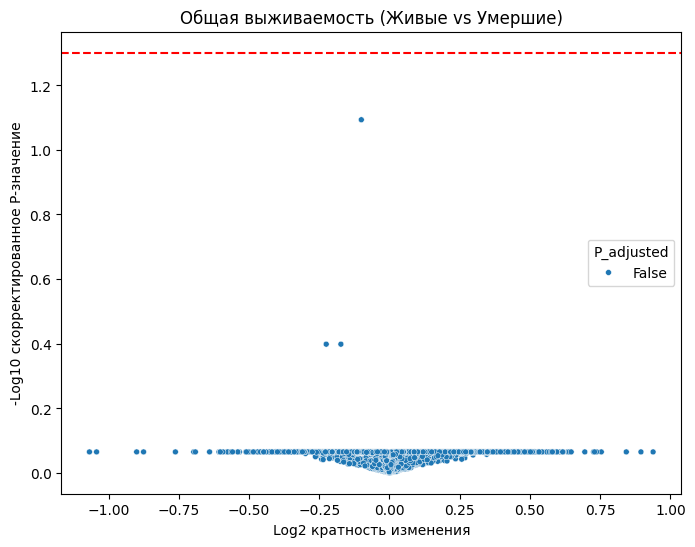

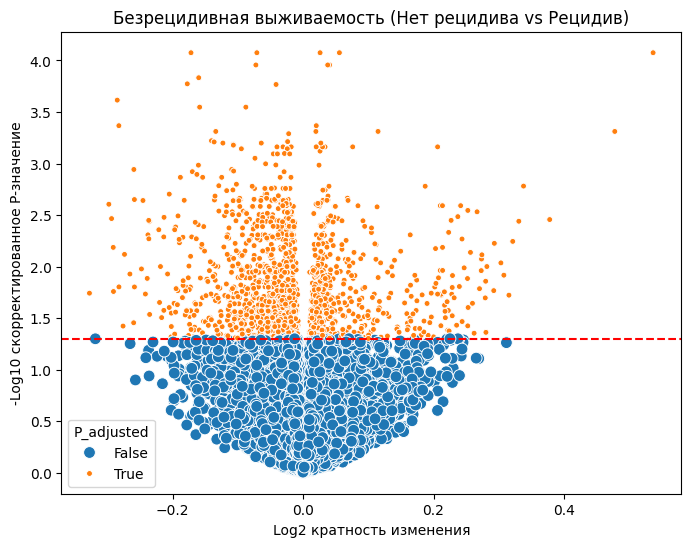

In [66]:
# 6. Визуализация
# Volcano plot для общей выживаемости (OS)
if not survival_results.empty:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=survival_results, x='LogFC', y=-np.log10(survival_results['P_adjusted']),
                    hue=(survival_results['P_adjusted'] < 0.05), size=(survival_results['P_adjusted'] < 0.05))
    plt.title('Общая выживаемость (Живые vs Умершие)')
    plt.xlabel('Log2 кратность изменения')
    plt.ylabel('-Log10 скорректированное P-значение')
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
    plt.show()
    plt.close()

# Volcano plot для безрецидивной выживаемости (RFS)
if not recurrence_results.empty:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=recurrence_results, x='LogFC', y=-np.log10(recurrence_results['P_adjusted']),
                    hue=(recurrence_results['P_adjusted'] < 0.05), size=(recurrence_results['P_adjusted'] < 0.05))
    plt.title('Безрецидивная выживаемость (Нет рецидива vs Рецидив)')
    plt.xlabel('Log2 кратность изменения')
    plt.ylabel('-Log10 скорректированное P-значение')
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
    plt.show()
    plt.close()

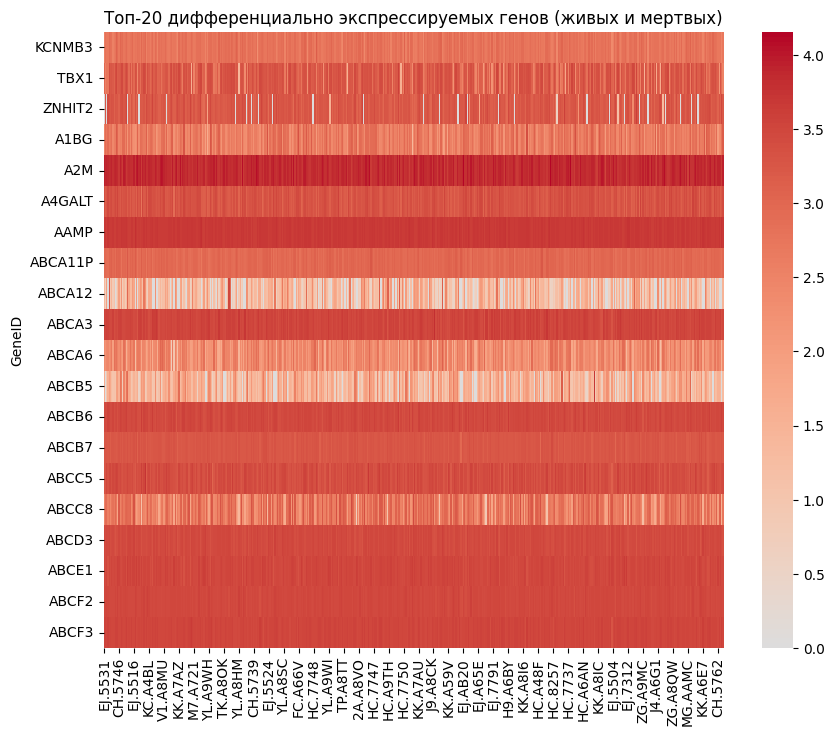

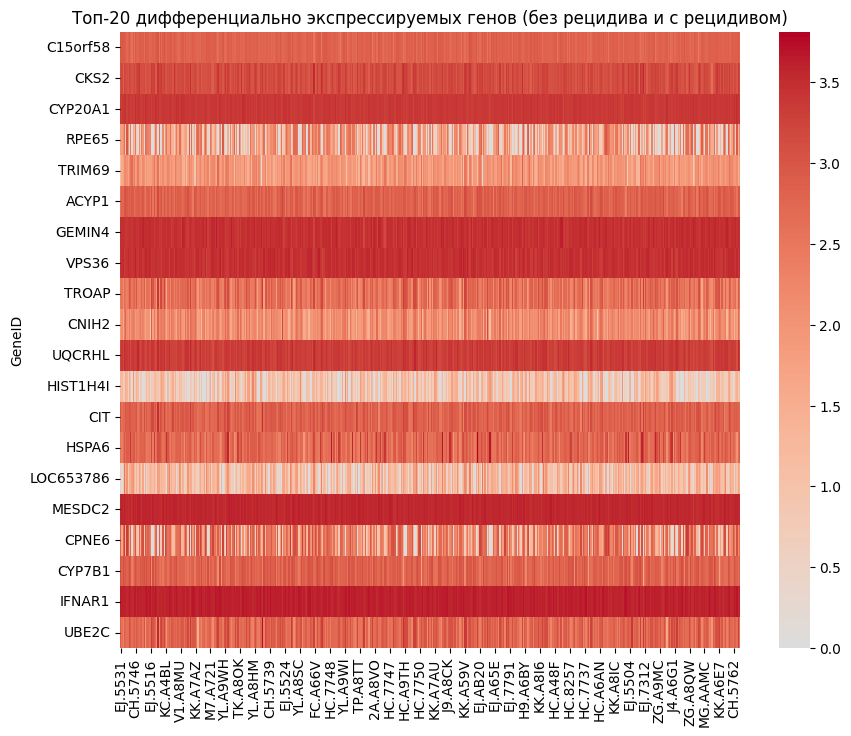

In [61]:
# Heatmap для топ-20 генов (статус выживания)
if not survival_results.empty:
    top_genes = survival_results.nsmallest(20, 'P_adjusted')['Gene']
    if len(top_genes) > 0:
        plt.figure(figsize=(10, 8))
        sns.heatmap(rna_data.loc[top_genes], cmap='coolwarm', center=0)
        plt.title('Топ-20 дифференциально экспрессируемых генов (живых и мертвых)')
        plt.show()
        plt.close()

# Heatmap для топ-20 генов (рецидив)
if not recurrence_results.empty:
    top_genes = recurrence_results.nsmallest(20, 'P_adjusted')['Gene']
    if len(top_genes) > 0:
        plt.figure(figsize=(10, 8))
        sns.heatmap(rna_data.loc[top_genes], cmap='coolwarm', center=0)
        plt.title('Топ-20 дифференциально экспрессируемых генов (без рецидива и с рецидивом)')
        plt.show()
        plt.close()

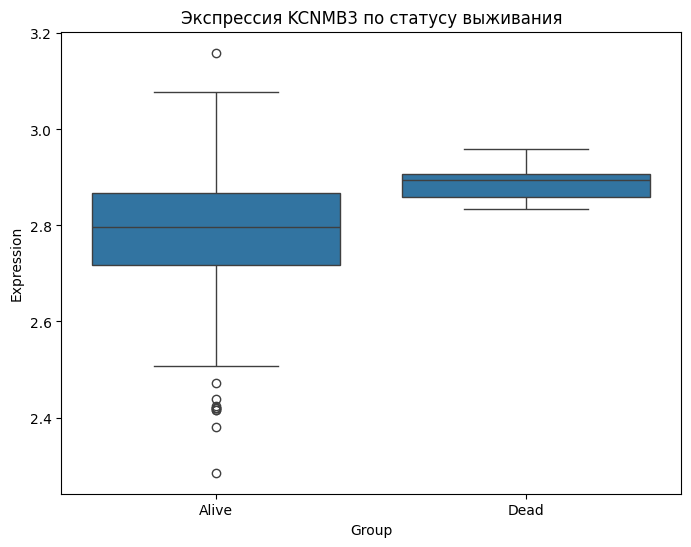

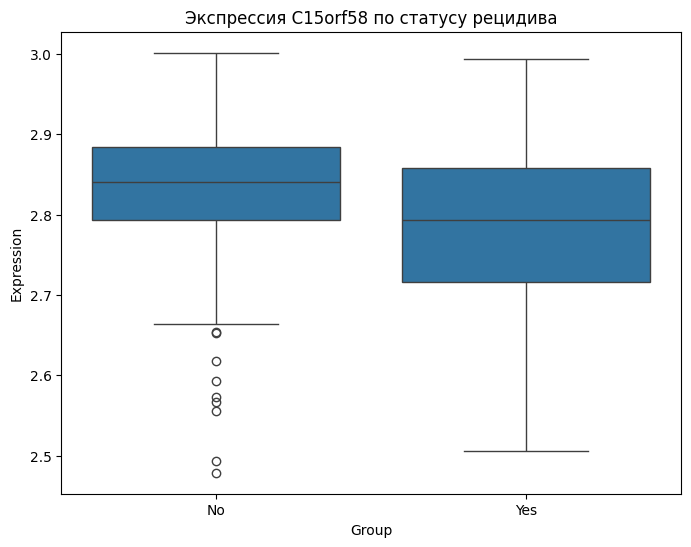

In [67]:
# Boxplot для топ-гена (статус выживания)
if not survival_results.empty:
    top_gene = survival_results.nsmallest(1, 'P_adjusted')['Gene'].iloc[0]
    plt.figure(figsize=(8, 6))
    data = pd.DataFrame({
        'Expression': rna_data.loc[top_gene],
        'Group': clinical_data.set_index('patient_id_clean')['status'].reindex(rna_data.columns).map({0: 'Alive', 1: 'Dead'})
    })
    sns.boxplot(x='Group', y='Expression', data=data)
    plt.title(f'Экспрессия {top_gene} по статусу выживания')
    plt.show()
    plt.close()

# Boxplot для топ-гена (рецидив)
if not recurrence_results.empty:
    top_gene = recurrence_results.nsmallest(1, 'P_adjusted')['Gene'].iloc[0]
    plt.figure(figsize=(8, 6))
    data = pd.DataFrame({
        'Expression': rna_data.loc[top_gene],
        'Group': clinical_data.set_index('patient_id_clean')['recurrence_mapped'].reindex(rna_data.columns)
    })
    sns.boxplot(x='Group', y='Expression', data=data)
    plt.title(f'Экспрессия {top_gene} по статусу рецидива')
    plt.show()
    plt.close()

In [68]:
# 7. Сохранение результатов
if not survival_results.empty:
    survival_results.to_csv('survival_de_results.csv', index=False)
    print("Таблица результатов для статуса выживания сохранена в 'survival_de_results.csv'")
    try:
        files.download('survival_de_results.csv')
    except:
        print("Не в Colab. Файл сохранён локально.")

if not recurrence_results.empty:
    recurrence_results.to_csv('recurrence_de_results.csv', index=False)
    print("Таблица результатов для рецидива сохранена в 'recurrence_de_results.csv'")
    try:
        files.download('recurrence_de_results.csv')
    except:
        print("Не в Colab. Файл сохранён локально.")

rna_data.reset_index().to_csv('cleaned_rnaseq.csv', index=False)
print("Очищенный RNA-seq датасет сохранён в 'cleaned_rnaseq.csv'")
try:
    files.download('cleaned_rnaseq.csv')
except:
    print("Не в Colab. Файл сохранён локально.")

print("\nАнализ завершён! Проверьте скачанные файлы и графики.")

Таблица результатов для статуса выживания сохранена в 'survival_de_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Таблица результатов для рецидива сохранена в 'recurrence_de_results.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Очищенный RNA-seq датасет сохранён в 'cleaned_rnaseq.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Анализ завершён! Проверьте скачанные файлы и графики.
